In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import os
from tqdm import tqdm

import rasterio
from rasterio.windows import Window
from pyproj import CRS

### Entrenamos un modelo de juguete con el dataset de la clase 11

El dataset es el que sale de SampleExtraction, que luego se usa en TrainVectorClassifier.

Link: https://storage.googleapis.com/gis2022-teledeteccion/clase11/extra/samples.sqlite

Con `ogr2ogr -f "CSV" samples.csv samples.sqlite` lo pasan a CSV

In [2]:
df = pd.read_csv('samples.csv')
df['ratio_1'] = df['band_0']/df['band_5']
df['ratio_2'] = df['band_0']/df['band_4']
df.head()

,in1,id,cultivo,originfid,band_0,band_1,band_2,band_3,band_4,band_5,ratio_1,ratio_2
0,14035,3,MAIZ,409,0.294909,0.291342,0.284329,0.350873,0.282852,0.306162,0.963244,1.042627
1,14084,1,SOJA,56,0.319566,0.372597,0.377740,0.600653,0.676652,0.260705,1.225777,0.472275
2,14084,1,SOJA,57,0.333868,0.351675,0.320528,0.557252,0.581662,0.409957,0.814397,0.573989
3,14084,1,SOJA,59,0.399241,0.377706,0.234728,0.352085,0.541737,0.517532,0.771433,0.736964
4,14084,2,MAIZ,53,0.372678,0.382177,0.360437,0.475942,0.432502,0.248573,1.499270,0.861679


In [3]:
X = df[['band_0','band_1','band_2','band_3','band_4','band_5', 'ratio_1', 'ratio_2']]
y = df['id']

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=5, random_state=0)

### Se lo aplicamos a la imagen

La imagen se encuentra en https://storage.googleapis.com/gis2022-teledeteccion/clase11/extra/input_merge.tif

`wget https://storage.googleapis.com/gis2022-teledeteccion/clase11/extra/input_merge.tif`

In [4]:
tile = 'input_merge.tif'

#### Funciones auxiliares

In [5]:
def metadata_from_tile(in_raster):
    with rasterio.open(in_raster) as src:
        return(src.width, src.height, src.transform)

def sliding_windows(size, step_size, width, height, whole=False):
    """Slide a window of +size+ by moving it +step_size+ pixels"""
    w, h = size, size
    sw, sh = step_size, step_size
    end_i = height - h if whole else height
    end_j = width - w if whole else width
    for pos_i, i in enumerate(range(0, end_i, sh)):
        for pos_j, j in enumerate(range(0, end_j, sw)):
            real_w = w if whole else min(w, abs(width - j))
            real_h = h if whole else min(h, abs(height - i))
            yield Window(j, i, real_w, real_h), (pos_i, pos_j)

In [6]:
width, height, transform = metadata_from_tile(tile)
windows = sliding_windows(100, 100, width, height)

In [7]:
width, height, transform

(3316,
 8653,
 Affine(0.0001796630568239043, 0.0, -62.86392391962729,
        0.0, -0.0001796630568239043, -33.815102577054326))

#### Ejemplo para una window cualquiera

In [8]:
window = list(windows)[1400]

In [9]:
#leemos esa parte de la imagen y creamos las bandas según se crearon para el modelo original
src = rasterio.open(tile)
img = src.read(window=window[0]) 
r,m,n = img.shape
img_df = pd.DataFrame(img.reshape(r,m*n)).T.fillna(-99)
bands = ['band_0','band_1','band_2','band_3','band_4','band_5']
img_df.columns = bands
img_df['ratio_1'] = img_df['band_0']/img_df['band_5']
img_df['ratio_2'] = img_df['band_0']/img_df['band_4']
img_df

,band_0,band_1,band_2,band_3,band_4,band_5,ratio_1,ratio_2
0,0.367403,0.371982,0.495812,0.342274,0.456534,0.368658,0.996596,0.804766
1,0.382199,0.383686,0.495812,0.345412,0.490427,0.381339,1.002254,0.779319
2,0.373443,0.380242,0.494694,0.357949,0.470606,0.367226,1.016930,0.793537
3,0.376706,0.377904,0.435837,0.312673,0.481719,0.364336,1.033953,0.782004
4,0.381546,0.380462,0.453426,0.317450,0.473962,0.338122,1.128426,0.805015
...,...,...,...,...,...,...,...,...
9995,0.249314,0.270202,0.256313,0.574499,0.616349,0.395085,0.631039,0.404501
9996,0.247663,0.267347,0.279493,0.608434,0.650614,0.402501,0.615309,0.380660
9997,0.231855,0.262623,0.284219,0.603604,0.639775,0.408507,0.567567,0.362401
9998,0.247257,0.278644,0.300000,0.613406,0.635927,0.407027,0.607471,0.388813


In [10]:
res = clf.predict(img_df).astype(np.float64)
res = np.expand_dims(res.reshape(n,m), axis=0)
res.shape

(1, 100, 100)

Pasemos este procedimiento a una función para que sea más cómodo. Recordar agregar todas las combinaciones de bandas y procedimientos que apliquemos sobre el dataset de entrada al modelo.

In [11]:
def create_windowed_dataset(in_raster, window, bands_list):
    img_df = pd.DataFrame()
    src = rasterio.open(in_raster)
    img = src.read(window=window)
    r,m,n = img.shape
    img_df = pd.DataFrame(img.reshape(r,m*n)).T
    img_df.columns = bands_list
    img_df['ratio_1'] = img_df['band_0']/img_df['band_5']
    img_df['ratio_2'] = img_df['band_0']/img_df['band_4']
    img_df = img_df.replace([np.inf, -np.inf], np.nan).fillna(-99)
    return(img_df)

## Aplicamos para toda el área del tile de entrada

In [12]:
width, height, transform = metadata_from_tile(tile)
bands = ['band_0','band_1','band_2','band_3','band_4','band_5']
#agrandar si tienen mas memoria, corre un poco mas rapido pero ojo que se pueden distorsionar los bordes
windows = sliding_windows(100, 100, width, height)
os.makedirs('./predictions/', exist_ok=True)
out_raster = f'./predictions/{tile}'
with rasterio.open(out_raster, 'w', driver='GTiff', count=1, width=width, height=height, dtype=np.float64, transform=transform, crs=CRS.from_epsg(4326), compress='lzw'
) as dst:
    for window, _ in tqdm(windows):           
        img_df = create_windowed_dataset(tile, window, bands)
        n_bands = img_df.shape[1]
        r,m,n = (n_bands, window.width, window.height)
        #clf es el clasificador que entrenamos antes
        res = clf.predict(img_df).astype(np.float64)
        res = np.expand_dims(res.reshape(m,n), axis=0)
        dst.write(res, window=window)

2958it [02:13, 22.09it/s]


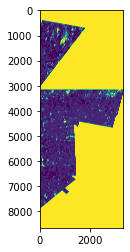

In [13]:
from matplotlib import pyplot
src = rasterio.open(out_raster)
pyplot.imshow(src.read(1))
pyplot.show()